In [1]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

geo = "GSE76462"

In [2]:
data = GEOparse.get_GEO(geo=geo, destdir="../Dataset/Marzi2016", silent=True)

In [3]:
data.metadata["platform_id"][0]

'GPL21291'

In [4]:
data.gpls[data.metadata["platform_id"][0]].table

,ID,miRNA_ID,Accession,SEQUENCE
0,hsa-mir-92a-000431,hsa-mir-92a-3p,MI0000094,UAUUGCACUUGUCCCGGCCUGU
1,hsa-mir-484-001821,hsa-mir-484,MI0002468,UCAGGCUCAGUCCCCUCCCGAU
2,hsa-mir-328-000543,hsa-mir-328-3p,MI0000804,CUGGCCCUCUCUGCCCUUCCGU
3,hsa-mir-191-002299,hsa-mir-191-5p,MI0000465,CAACGGAAUCCCAAAAGCAGCUG
4,hsa-mir-331-3p-000545,hsa-mir-331-3p,MI0000812,GCCCCUGGGCCUAUCCUAGAA
5,hsa-mir-30c-000419,hsa-mir-30c-5p,MI0000736,UGUAAACAUCCUACACUCUCAGC
6,hsa-miR-374a-000563,hsa-miR-374a-5p,MI0000782,UUAUAAUACAACCUGAUAAGUG
7,hsa-mir-30b-000602,hsa-mir-30b-5p,MI0000441,UGUAAACAUCCUACACUCAGCU
8,hsa-let-7d-002283,hsa-let-7d-5p,MI0000065,AGAGGUAGUAGGUUGCAUAGUU
9,hsa-mir-223-002295,hsa-mir-223-3p,MI0000300,UGUCAGUUUGUCAAAUACCCCA


In [5]:
list(data.gsms.values())[1].metadata

{'title': ['T02'],
 'geo_accession': ['GSM2025020'],
 'status': ['Public on Feb 29 2016'],
 'submission_date': ['Dec 31 2015'],
 'last_update_date': ['Feb 29 2016'],
 'type': ['RNA'],
 'channel_count': ['1'],
 'source_name_ch1': ['Serum'],
 'organism_ch1': ['Homo sapiens'],
 'taxid_ch1': ['9606'],
 'characteristics_ch1': ['group: TUMOR-CALIBRATION',
  'sample type: Case',
  'tumor type: Lung Adenocarcinoma'],
 'molecule_ch1': ['total RNA'],
 'extract_protocol_ch1': ['Blood collection: Blood samples (10 ml) were collected by standard phlebotomy before any analysis or instrumental procedure. The first 3 mL of blood were not used for serum preparation to prevent contamination by skin. Serum was prepared by collecting blood in tubes with clot activator (S-Monovette 7.5ml REF01.1601 â€“ Sarstedt), left at room temperature for 3 hours to clot, then spun at 3000 rpm (1000 g, Megafuge 2.0 Heraeus) for 10 minutes at RT. The serum was removed immediately after centrifugation, leaving a 0.5 cm le

In [6]:
table = pd.concat((val.table.iloc[:,1:2] for val in data.gsms.values()), axis=1).transpose()

In [7]:
(table > 0).all(0)

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
dtype: bool

In [8]:
#table = table.loc[:, (table > 0).all(0)]
table = table.dropna(1)

C:\Users\olefr\AppData\Local\Temp/ipykernel_2992/3290136690.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  table = table.dropna(1)


In [9]:
table

,0,1,2,3,4,5,6,7,8,9,10,11,12
VALUE,20.35,19.55,23.06,19.40,25.30,21.84,27.28,22.45,25.03,12.62,24.17,23.83,22.36
VALUE,20.42,19.18,22.83,18.95,24.49,22.50,26.24,21.10,26.34,13.04,25.09,25.10,22.78
VALUE,20.50,19.49,23.24,19.23,24.65,22.37,25.96,21.44,26.48,13.25,25.12,25.16,22.93
VALUE,20.31,19.01,23.12,19.25,25.21,22.33,26.52,21.68,26.29,14.37,25.84,25.38,23.50
VALUE,20.01,18.82,23.70,19.89,25.63,22.76,26.81,21.94,26.17,14.42,25.73,25.59,23.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,19.25,17.34,22.90,18.06,23.97,22.25,26.32,22.45,27.45,14.59,26.29,25.76,23.67
VALUE,20.47,19.14,24.27,19.68,25.73,24.45,27.52,24.15,28.28,15.47,26.04,25.31,24.44
VALUE,21.76,19.41,23.56,18.66,25.14,23.47,27.61,23.37,27.38,13.73,26.14,26.74,23.78
VALUE,20.78,19.15,24.14,19.25,25.80,24.38,27.38,23.92,28.14,14.39,26.19,27.25,24.47


In [10]:
np.mean(table)

0     20.130426
1     19.393973
2     23.665107
3     19.538130
4     25.409593
5     23.246269
6     26.473624
7     22.588479
8     26.393110
9     15.181308
10    26.584729
11    26.800388
12    24.635155
dtype: float64

In [11]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [12]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

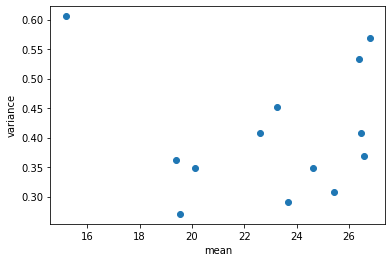

In [13]:
mean_variance_plot(table)

### Trying log-transformation

In [14]:
log_table = table #np.log2(table)

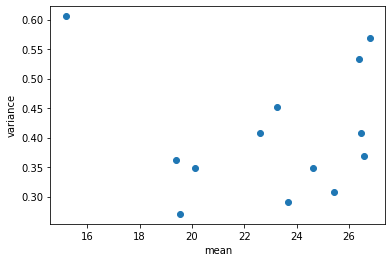

In [15]:
mean_variance_plot(log_table)

In [16]:
norm_log_table = log_table #- np.mean(log_table)

In [17]:
#norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

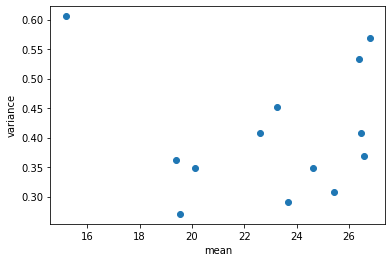

In [18]:
mean_variance_plot(norm_log_table)

In [19]:
pca = decomposition.PCA(n_components=2)

In [20]:
pca.fit(norm_log_table)

PCA(n_components=2)

In [21]:
components = pca.transform(norm_log_table)

In [22]:
components

array([[ 0.5803939 , -5.18318514],
       [-0.37474156, -3.97004515],
       [-0.11723428, -3.69855251],
       ...,
       [ 1.45247175, -0.86070456],
       [ 2.43960306,  0.53088956],
       [ 2.1293731 ,  0.55693118]])

In [23]:
list(data.gsms.values())[-1].metadata

{'title': ['W999'],
 'geo_accession': ['GSM2026050'],
 'status': ['Public on Feb 29 2016'],
 'submission_date': ['Dec 31 2015'],
 'last_update_date': ['Feb 29 2016'],
 'type': ['RNA'],
 'channel_count': ['1'],
 'source_name_ch1': ['Serum'],
 'organism_ch1': ['Homo sapiens'],
 'taxid_ch1': ['9606'],
 'characteristics_ch1': ['group: SCREENING', 'sample type: Control'],
 'molecule_ch1': ['total RNA'],
 'extract_protocol_ch1': ['Blood collection: Blood samples (10 ml) were collected by standard phlebotomy before any analysis or instrumental procedure. The first 3 mL of blood were not used for serum preparation to prevent contamination by skin. Serum was prepared by collecting blood in tubes with clot activator (S-Monovette 7.5ml REF01.1601 â€“ Sarstedt), left at room temperature for 3 hours to clot, then spun at 3000 rpm (1000 g, Megafuge 2.0 Heraeus) for 10 minutes at RT. The serum was removed immediately after centrifugation, leaving a 0.5 cm leftover to avoid disturbing the serum-clot i

In [24]:
controls = np.array(["Control" in k.metadata["characteristics_ch1"][1] for k in list(data.gsms.values())])

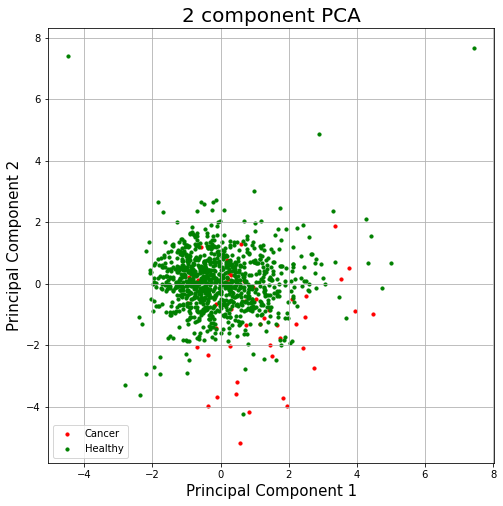

In [25]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

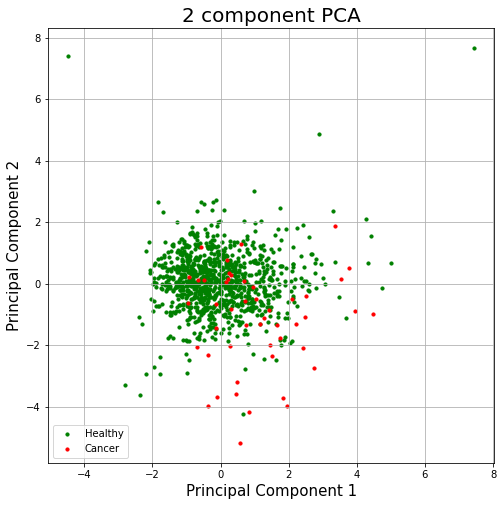

In [26]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy'][::-1]
colors = ['r', 'g']
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [27]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [28]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


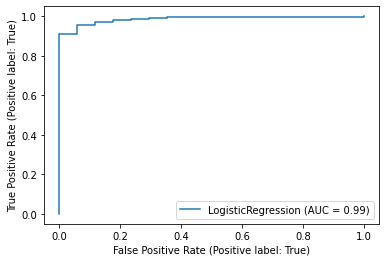

In [29]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [30]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [31]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[19:05:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


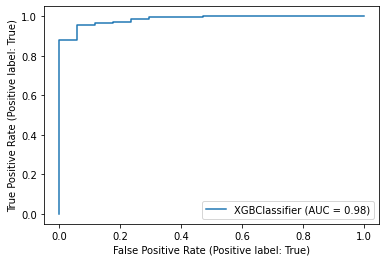

In [32]:
plot_roc_curve(model, X_test, y_test)

### Export dataset

In [33]:
mirnas = list(data.gsms.values())[0].table.iloc[:, 0]

In [34]:
mirnas

0        hsa-mir-92a-000431
1        hsa-mir-484-001821
2        hsa-mir-328-000543
3        hsa-mir-191-002299
4     hsa-mir-331-3p-000545
5        hsa-mir-30c-000419
6       hsa-miR-374a-000563
7        hsa-mir-30b-000602
8         hsa-let-7d-002283
9        hsa-mir-223-002295
10       hsa-mir-29a-002112
11      hsa-mir-148a-000470
12    hsa-mir-140-5p-001187
Name: ID_REF, dtype: object

In [35]:
lookup_table = data.gpls[data.metadata["platform_id"][0]].table.set_index("ID")

In [36]:
lookup_table.head()

,miRNA_ID,Accession,SEQUENCE
ID,,,
hsa-mir-92a-000431,hsa-mir-92a-3p,MI0000094,UAUUGCACUUGUCCCGGCCUGU
hsa-mir-484-001821,hsa-mir-484,MI0002468,UCAGGCUCAGUCCCCUCCCGAU
hsa-mir-328-000543,hsa-mir-328-3p,MI0000804,CUGGCCCUCUCUGCCCUUCCGU
hsa-mir-191-002299,hsa-mir-191-5p,MI0000465,CAACGGAAUCCCAAAAGCAGCUG
hsa-mir-331-3p-000545,hsa-mir-331-3p,MI0000812,GCCCCUGGGCCUAUCCUAGAA


In [37]:
sequences = lookup_table.loc[mirnas]["SEQUENCE"]

In [38]:
norm_log_table.columns = sequences

In [39]:
norm_log_table *= -1
norm_log_table["cancer"] = 1-controls
norm_log_table.head()

SEQUENCE,UAUUGCACUUGUCCCGGCCUGU,UCAGGCUCAGUCCCCUCCCGAU,CUGGCCCUCUCUGCCCUUCCGU,CAACGGAAUCCCAAAAGCAGCUG,GCCCCUGGGCCUAUCCUAGAA,UGUAAACAUCCUACACUCUCAGC,UUAUAAUACAACCUGAUAAGUG,UGUAAACAUCCUACACUCAGCU,AGAGGUAGUAGGUUGCAUAGUU,UGUCAGUUUGUCAAAUACCCCA,UAGCACCAUCUGAAAUCGGUUA,UCAGUGCACUACAGAACUUUGU,CAGUGGUUUUACCCUAUGGUAG,cancer
VALUE,-20.35,-19.55,-23.06,-19.40,-25.30,-21.84,-27.28,-22.45,-25.03,-12.62,-24.17,-23.83,-22.36,1
VALUE,-20.42,-19.18,-22.83,-18.95,-24.49,-22.50,-26.24,-21.10,-26.34,-13.04,-25.09,-25.10,-22.78,1
VALUE,-20.50,-19.49,-23.24,-19.23,-24.65,-22.37,-25.96,-21.44,-26.48,-13.25,-25.12,-25.16,-22.93,1
VALUE,-20.31,-19.01,-23.12,-19.25,-25.21,-22.33,-26.52,-21.68,-26.29,-14.37,-25.84,-25.38,-23.50,1
VALUE,-20.01,-18.82,-23.70,-19.89,-25.63,-22.76,-26.81,-21.94,-26.17,-14.42,-25.73,-25.59,-23.38,1


In [40]:
norm_log_table.to_csv("../TransformedData/Marzi2016_raw.csv", index=False)